In [1]:
import os
import sys
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
import glob
import dask.array as da


In [2]:
data_dir = '/Users/tim/work/results/acdc/half_ocean_newbucket_0qflux_control'
globname = data_dir + '/*/*.nc'
file_list = glob.glob(globname)
file_list = sorted(file_list)
ds_ctrl = xr.open_mfdataset(file_list,autoclose='true')

lat = ds_ctrl['lat'].values[:]
lon = ds_ctrl['lon'].values[:]
lev = ds_ctrl['pfull'].values[:]

/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/Users/tim/anaconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])


In [3]:
ds_ctrl

<xarray.Dataset>
Dimensions:            (lat: 64, latb: 65, lon: 128, lonb: 129, nv: 2, pfull: 40, phalf: 41, time: 137)
Coordinates:
  * lon                (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * lonb               (lonb) float64 -1.406 1.406 4.219 7.031 9.844 12.66 ...
  * lat                (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 ...
  * latb               (latb) float64 -90.0 -86.58 -83.76 -80.96 -78.16 ...
  * nv                 (nv) float64 1.0 2.0
  * phalf              (phalf) float64 0.0 0.07368 0.2651 0.7976 2.052 4.604 ...
  * pfull              (pfull) float64 0.0271 0.1596 0.5078 1.377 3.244 ...
  * time               (time) object 0001-01-16 00:00:00 0001-02-16 00:00:00 ...
Data variables:
    ps                 (time, lat, lon) float32 dask.array<shape=(137, 64, 128), chunksize=(1, 64, 128)>
    bk                 (time, phalf) float32 dask.array<shape=(137, 41), chunksize=(1, 41)>
    pk                 (time, phalf) float32 dask.array<shap

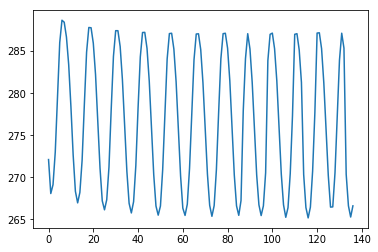

In [4]:
spatial_mean_temp = ds_ctrl['t_surf'].mean('lat').mean('lon').values[:]
t=range(np.shape(ds_ctrl['time'].values[:])[0])
plt.plot(spatial_mean_temp)
plt.show()

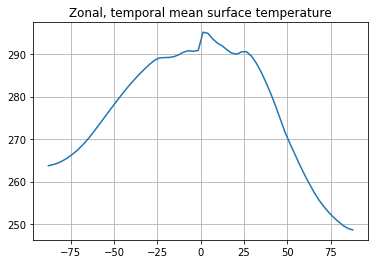

In [5]:
time_mean_temp = ds_ctrl['t_surf'].mean('time')
#plt.pcolor(time_mean_temp,cmap='YlGnBu')
#plt.colorbar()

zon_surf_temp = ds_ctrl['t_surf'].mean('lon').mean('time')
plt.plot(lat,zon_surf_temp)
plt.title('Zonal, temporal mean surface temperature')
plt.grid()
plt.show()

## Precipitation
Lets look at 
- temporal mean spatial distribution of precipitation
- Hovmöller plot, time vs zonal mean
- The extremes: Jan - July

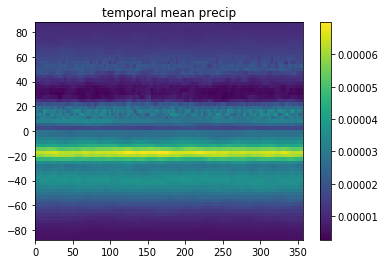

In [6]:
time_mean_precip = ds_ctrl['precipitation'].mean('time')

plt.pcolor(lon,lat,time_mean_precip.values)
plt.colorbar()
plt.title('temporal mean precip')
plt.show()

In [7]:

#ax = plt.axes(projection=ccrs.Mollweide())
#ax.set_global()
##cyclic_data, cyclic_lons = add_cyclic_point(time_mean_precip.values[:],coord=lon)
##cs = plt.pcolormesh(cyclic_lons,lat,cyclic_data,transform=ccrs.PlateCarree())
#tmpv=time_mean_precip.values[:]
#plt.pcolor(lon,lat,tmpv,transform=ccrs.PlateCarree())
####plt.set_cmap(copy(plt.cm.viridis))
##plt.show()


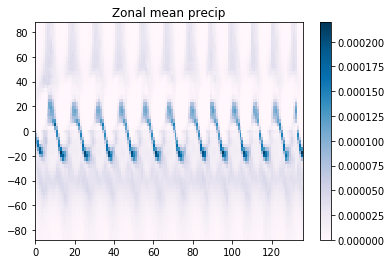

In [8]:
zon_hov_precip = ds_ctrl['precipitation'].mean('lon')
plt.pcolor(t,lat,zon_hov_precip.T,cmap='PuBu')
plt.colorbar()
plt.title('Zonal mean precip')
plt.show()

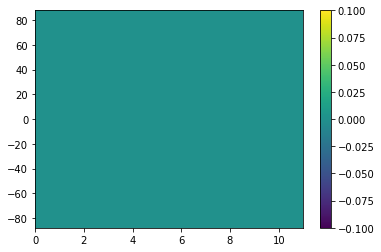

In [31]:
# --- This is where it all went to shit

# First compute departure from time mean
precip_mean_departure = ds_ctrl['precipitation'] - ds_ctrl['precipitation'].mean(dim='time') 
Nyrs = int(np.ceil(len(t) / 12))

# Now compute annual mean, subtract out 
precip_annual_mean = xr.DataArray(da.from_array(np.zeros([Nyrs,len(lat),len(lon)]),(1,len(lat),len(lon))), \
                                  [('time',np.arange(Nyrs)),('lat',lat),('lon',lon)])
precip_sub_annual = xr.DataArray(da.from_array(np.zeros([len(t),len(lat),len(lon)]),(1,len(lat),len(lon))), \
                                  [('time',ds_ctrl['time']),('lat',lat),('lon',lon)])
for n in range(0,Nyrs):
    st = n*12
    ed = np.min([(n+1)*12-1, len(t)])
    precip_annual_mean.isel(time=n).values = precip_mean_departure.isel(time=slice(st,ed)).mean('time').values
    precip_sub_annual.isel(time=n).values = precip_mean_departure.isel(time=slice(st,ed)).mean('time').values \
                                     - precip_annual_mean.isel(time=n).values
    
# Compute climatology with any trends removed    
precip_clim = xr.DataArray(da.from_array(np.zeros([12,len(lat),len(lon)]),(1,len(lat),len(lon))), \
                                  [('time',np.arange(12)),('lat',lat),('lon',lon)])
precip_clim_2 = xr.DataArray(da.from_array(np.zeros([12,len(lat),len(lon)]),(1,len(lat),len(lon))), \
                                  [('time',np.arange(12)),('lat',lat),('lon',lon)])
for n in range(0,12):    
    precip_clim.isel(time=n).values = precip_sub_annual.isel(time=slice(n,len(t),12)).mean('time').values 
    precip_clim_2.isel(time=n).values = ds_ctrl['precipitation'].isel(time=slice(n,len(t),12)).mean('time').values

# Compute zonal mean
zonal_mean_clim = precip_clim_2.mean('lon')

t_clim = np.arange(12)
plt.figure()
plt.pcolor(t_clim,lat,zonal_mean_clim.T)
plt.colorbar()

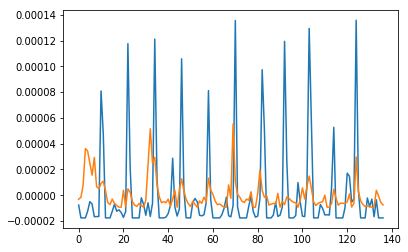

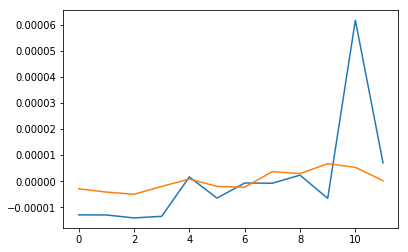

In [22]:
p_eq = ds_ctrl['precipitation'].sel(lat=0,lon=100,method='nearest')
p_st = ds_ctrl['precipitation'].sel(lat=40,lon=100,method='nearest')

p_eq = p_eq - p_eq.mean('time') 
p_st = p_st - p_st.mean('time')

p_eq_clim = np.zeros(12)
p_st_clim = np.zeros(12)
for n in range(12):
    p_eq_clim[n] = np.mean(p_eq.values[np.arange(n,len(t),12)])
    p_st_clim[n] = np.mean(p_st.values[np.arange(n,len(t),12)])
    
plt.figure()    
plt.plot(t,p_eq,t,p_st)
plt.figure()
plt.plot(t_clim,p_eq_clim,t_clim,p_st_clim)